Let's train AlexNet from scratch!

In [1]:
%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import numpy as np

import datasets
import torch

from datasets import load_dataset
from torchvision import transforms
from typing import Tuple

from trainer import Trainer
from utils import get_device, imshow

/home/a75wu/miniconda3/envs/dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setup device
device = get_device()

Using CUDA...


### Training configurations

In [3]:
NUM_EPOCHS = 30 # roughly ~90 cycles specified in alexnet paper
BATCH_SIZE = 128 # original paper uses 128
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
LEARNING_RATE = 0.01
NUM_CLASSES = 200 # tiny imagenet

# Dataset

We're going to use hugging face to load our dummy dataset (Tiny Imagenet) for training.

In [4]:
train_data = load_dataset('zh-plus/tiny-imagenet', split='train')
test_data = load_dataset('zh-plus/tiny-imagenet', split='valid')
print(f'train: {len(train_data)}, test: {len(test_data)}')

train: 100000, test: 10000


In [5]:
class TinyImageNetDataset(torch.utils.data.Dataset):

    def __init__(self, hf_dataset: datasets.Dataset, transforms: transforms.Compose = None) -> None:
        self.dataset = hf_dataset
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.dataset)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        sample = self.dataset[idx]

        if self.transforms:
            # some images are apparently greyscale so we need to convert to RGB
            sample["image"] = self.transforms(sample["image"].convert("RGB"))

        image, label = sample["image"], sample["label"]

        return image, label

In [6]:
# data preprocessing

train_transform = transforms.Compose([
    transforms.Resize(227),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_set = TinyImageNetDataset(train_data, train_transform)
test_set = TinyImageNetDataset(test_data, test_transform)

# split into 90-10 train and validation dataset
train_set, val_set = torch.utils.data.random_split(train_set, [0.9, 0.1])

# NOTE: apparently adding num_workers is very important for improving training speed lol
# https://stackoverflow.com/questions/53998282/how-does-the-number-of-workers-parameter-in-pytorch-dataloader-actually-work
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [7]:
print(f"train: {len(train_dataloader)}\nvalidation: {len(val_dataloader)}\ntest: {len(test_dataloader)}")

train: 704
validation: 79
test: 79


In [8]:
image, label = next(iter(train_dataloader))
image.shape

torch.Size([128, 3, 227, 227])

# Observe Pretrained AlexNet
Let's see what the pytorch AlexNet looks like

In [9]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)

Using cache found in /home/a75wu/.cache/torch/hub/pytorch_vision_v0.10.0
/home/a75wu/miniconda3/envs/dev/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/a75wu/miniconda3/envs/dev/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Some of the implementation details of the current pytorch model is a different than the original AlexNet paper but this github issue goes into some detail about it:

https://github.com/pytorch/vision/issues/549

NOTE: 
> "we added the avg_pool to make the model support images of different sizes. For images of size 224x224, the avg_pool is a no-op."

**We will try our best to implement the EXACT model mentioned in the paper instead of the PyTorch implementation**

# Our AlexNet Implementation

In [11]:
from alexnet import AlexNet
model = AlexNet()
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2):

In [12]:
n_params = sum(p.numel() for p in model.parameters())
n_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {n_params}")
print(f"Number of trainable parameters: {n_trainable_params}")

Number of parameters: 62378344
Number of trainable parameters: 62378344


In [13]:
alexnet_trainer = Trainer(model,
                          batch_size=BATCH_SIZE,
                          learning_rate=LEARNING_RATE,
                          weight_decay=WEIGHT_DECAY,
                          momentum=MOMENTUM,
                          num_epochs=NUM_EPOCHS,
                          device=device)
alexnet_trainer.train(train_dataloader, val_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:37<00:00,  7.19it/s, loss=5.37]


INFO | [EPOCH 1] LOSS : train=5.6569632718508895 val=5.361310868323604 | ACCURACY (Top-1) : train=0.00456099072471261 val=0.004647943191230297 | TOP-5 : train=0.024158824573863636 val=0.023635284810126583


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:39<00:00,  7.11it/s, loss=5.34]


INFO | [EPOCH 2] LOSS : train=5.356095892461863 val=5.3487432878228685 | ACCURACY (Top-1) : train=0.004827326163649559 val=0.005735759623348713 | TOP-5 : train=0.02434747869318182 val=0.025118670886075948


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:32<00:00,  7.62it/s, loss=5.13]


INFO | [EPOCH 3] LOSS : train=5.257141777737574 val=5.10165585747248 | ACCURACY (Top-1) : train=0.007956765592098236 val=0.01275712065398693 | TOP-5 : train=0.038507634943181816 val=0.05844541139240506


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:42<00:00,  6.84it/s, loss=4.92]


INFO | [EPOCH 4] LOSS : train=5.018083686178381 val=4.863555654694762 | ACCURACY (Top-1) : train=0.02147327922284603 val=0.0390625 | TOP-5 : train=0.08804598721590909 val=0.12895569620253164


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:36<00:00,  7.30it/s, loss=4.45]


INFO | [EPOCH 5] LOSS : train=4.66817624934695 val=4.410591222062895 | ACCURACY (Top-1) : train=0.049893468618392944 val=0.06784018874168396 | TOP-5 : train=0.1739501953125 val=0.2331882911392405


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:39<00:00,  7.09it/s, loss=4]


INFO | [EPOCH 6] LOSS : train=4.199221126057885 val=4.047299366963061 | ACCURACY (Top-1) : train=0.1011962890625 val=0.12776899337768555 | TOP-5 : train=0.29114879261363635 val=0.32743275316455694


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:36<00:00,  7.26it/s, loss=3.66]


INFO | [EPOCH 7] LOSS : train=3.85190109197389 val=3.7797603788255136 | ACCURACY (Top-1) : train=0.15103426575660706 val=0.1643591821193695 | TOP-5 : train=0.38041548295454547 val=0.39408623417721517


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:38<00:00,  7.13it/s, loss=3.36]


INFO | [EPOCH 8] LOSS : train=3.417269053784284 val=3.3564166177677204 | ACCURACY (Top-1) : train=0.22166860103607178 val=0.2350672483444214 | TOP-5 : train=0.48197798295454547 val=0.4933742088607595


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:41<00:00,  6.91it/s, loss=3.4]


INFO | [EPOCH 9] LOSS : train=3.325157389722087 val=3.313815829120105 | ACCURACY (Top-1) : train=0.23643910884857178 val=0.2431764304637909 | TOP-5 : train=0.5035844282670454 val=0.5069224683544303


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:32<00:00,  7.58it/s, loss=3.26]


INFO | [EPOCH 10] LOSS : train=3.265972266820344 val=3.271509484399723 | ACCURACY (Top-1) : train=0.24708141386508942 val=0.25019779801368713 | TOP-5 : train=0.5155140269886364 val=0.514932753164557


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:38<00:00,  7.12it/s, loss=3.22]


INFO | [EPOCH 11] LOSS : train=3.2150866091251373 val=3.2310529479497596 | ACCURACY (Top-1) : train=0.2565252184867859 val=0.25632911920547485 | TOP-5 : train=0.5268332741477273 val=0.5234375


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:45<00:00,  6.69it/s, loss=3.14]


INFO | [EPOCH 12] LOSS : train=3.1671993864530865 val=3.1724180843256695 | ACCURACY (Top-1) : train=0.26481491327285767 val=0.26908624172210693 | TOP-5 : train=0.5379416725852273 val=0.5352056962025317


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:37<00:00,  7.25it/s, loss=3.06]


INFO | [EPOCH 13] LOSS : train=3.121407210826874 val=3.122367267367206 | ACCURACY (Top-1) : train=0.27268290519714355 val=0.2761076092720032 | TOP-5 : train=0.5489723899147727 val=0.5446993670886076


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:41<00:00,  6.92it/s, loss=3.07]


INFO | [EPOCH 14] LOSS : train=3.0817639726129444 val=3.138366729398317 | ACCURACY (Top-1) : train=0.28103914856910706 val=0.2761076092720032 | TOP-5 : train=0.5564963600852273 val=0.5436115506329114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:37<00:00,  7.20it/s, loss=3.02]


INFO | [EPOCH 15] LOSS : train=2.980340000241995 val=3.0474748309654527 | ACCURACY (Top-1) : train=0.2997491955757141 val=0.2939082384109497 | TOP-5 : train=0.5786354758522727 val=0.564873417721519


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:34<00:00,  7.42it/s, loss=3.05]


INFO | [EPOCH 16] LOSS : train=2.967280241914771 val=3.043632377552081 | ACCURACY (Top-1) : train=0.3021795153617859 val=0.2920292913913727 | TOP-5 : train=0.5815984552556818 val=0.5652689873417721


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:40<00:00,  7.01it/s, loss=2.92]


INFO | [EPOCH 17] LOSS : train=2.9573537788607855 val=3.025141785416422 | ACCURACY (Top-1) : train=0.3042657971382141 val=0.2967761158943176 | TOP-5 : train=0.5843505859375 val=0.5682357594936709


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:36<00:00,  7.30it/s, loss=2.95]


INFO | [EPOCH 18] LOSS : train=2.9505811773917894 val=3.0305239701572853 | ACCURACY (Top-1) : train=0.30465421080589294 val=0.29282042384147644 | TOP-5 : train=0.5847722833806818 val=0.5676424050632911


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:37<00:00,  7.19it/s, loss=2.9]


INFO | [EPOCH 19] LOSS : train=2.9441729692572896 val=3.028598344778713 | ACCURACY (Top-1) : train=0.30630770325660706 val=0.29568830132484436 | TOP-5 : train=0.5867919921875 val=0.5660601265822784


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:38<00:00,  7.17it/s, loss=2.93]


INFO | [EPOCH 20] LOSS : train=2.935957385057753 val=3.014673797390129 | ACCURACY (Top-1) : train=0.30728426575660706 val=0.2962816655635834 | TOP-5 : train=0.5887895063920454 val=0.5695213607594937


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:38<00:00,  7.15it/s, loss=2.88]


INFO | [EPOCH 21] LOSS : train=2.9312188113954933 val=3.024732378464711 | ACCURACY (Top-1) : train=0.3079279065132141 val=0.2977650463581085 | TOP-5 : train=0.5887451171875 val=0.5703125


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:39<00:00,  7.06it/s, loss=2.88]


INFO | [EPOCH 22] LOSS : train=2.9175763164054263 val=3.0081283352043053 | ACCURACY (Top-1) : train=0.31034713983535767 val=0.30251187086105347 | TOP-5 : train=0.5926513671875 val=0.572685917721519


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:39<00:00,  7.09it/s, loss=2.94]


INFO | [EPOCH 23] LOSS : train=2.915942318737507 val=3.0088868654226957 | ACCURACY (Top-1) : train=0.3112127184867859 val=0.2984572947025299 | TOP-5 : train=0.5915860262784091 val=0.5746637658227848


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:37<00:00,  7.20it/s, loss=2.89]


INFO | [EPOCH 24] LOSS : train=2.91580056399107 val=3.0050605792033522 | ACCURACY (Top-1) : train=0.31081321835517883 val=0.29934731125831604 | TOP-5 : train=0.5929953835227273 val=0.5714003164556962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:35<00:00,  7.36it/s, loss=2.91]


INFO | [EPOCH 25] LOSS : train=2.913320042531599 val=2.999567249153234 | ACCURACY (Top-1) : train=0.31143465638160706 val=0.3040941655635834 | TOP-5 : train=0.5926180752840909 val=0.5738726265822784


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:40<00:00,  6.98it/s, loss=3]


INFO | [EPOCH 26] LOSS : train=2.912034350362691 val=3.000708848615236 | ACCURACY (Top-1) : train=0.3120006322860718 val=0.2997428774833679 | TOP-5 : train=0.5922296697443182 val=0.571004746835443


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:36<00:00,  7.32it/s, loss=2.83]


INFO | [EPOCH 27] LOSS : train=2.9125874746929514 val=3.015918722635583 | ACCURACY (Top-1) : train=0.3126331865787506 val=0.297468364238739 | TOP-5 : train=0.5923517400568182 val=0.5695213607594937


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:38<00:00,  7.13it/s, loss=2.9]


INFO | [EPOCH 28] LOSS : train=2.912517122585665 val=2.9981011318255075 | ACCURACY (Top-1) : train=0.3111572265625 val=0.30191850662231445 | TOP-5 : train=0.5936279296875 val=0.575751582278481


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [01:39<00:00,  7.09it/s, loss=2.84]


INFO | [EPOCH 29] LOSS : train=2.910572686317292 val=3.000654649130906 | ACCURACY (Top-1) : train=0.3120672106742859 val=0.30290743708610535 | TOP-5 : train=0.5935169566761364 val=0.5732792721518988


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 477/704 [01:07<00:31,  7.11it/s, loss=2.83]


KeyboardInterrupt: 

# Test

## Performance Metrics
Let's implement Top-1 (accuracy) and Top-5 Error Rate Metrics

https://pytorch.org/ignite/generated/ignite.metrics.TopKCategoricalAccuracy.html

In [16]:
# test top-k accuracy metric
outputs = torch.tensor([
    [0.7, 0.2, 0.05, 0.05],     # 1 is in the top 2
    [0.2, 0.3, 0.4, 0.1],       # 0 is not in the top 2
    [0.4, 0.4, 0.1, 0.1],       # 0 is in the top 2
    [0.7, 0.05, 0.2, 0.05]      # 2 is in the top 2
])
labels = torch.tensor([1, 0, 0, 2])

k = 2
values, indices = torch.topk(outputs, k)
print(f"top-k indices:\n{indices}\n")

print(f"ground truths:\n{labels}")
print(labels.view(-1, 1).expand_as(indices))
topk_correct = indices.eq(labels.view(-1, 1).expand_as(indices))
accuracy = topk_correct.sum().item() / labels.size(0)

accuracy

top-k indices:
tensor([[0, 1],
        [2, 1],
        [1, 0],
        [0, 2]])

ground truths:
tensor([1, 0, 0, 2])
tensor([[1, 1],
        [0, 0],
        [0, 0],
        [2, 2]])


0.75

## Evaluate

INFO | Test accuracy: 31.754350662231445 % | Top-5 accuracy: 58.7618670886076


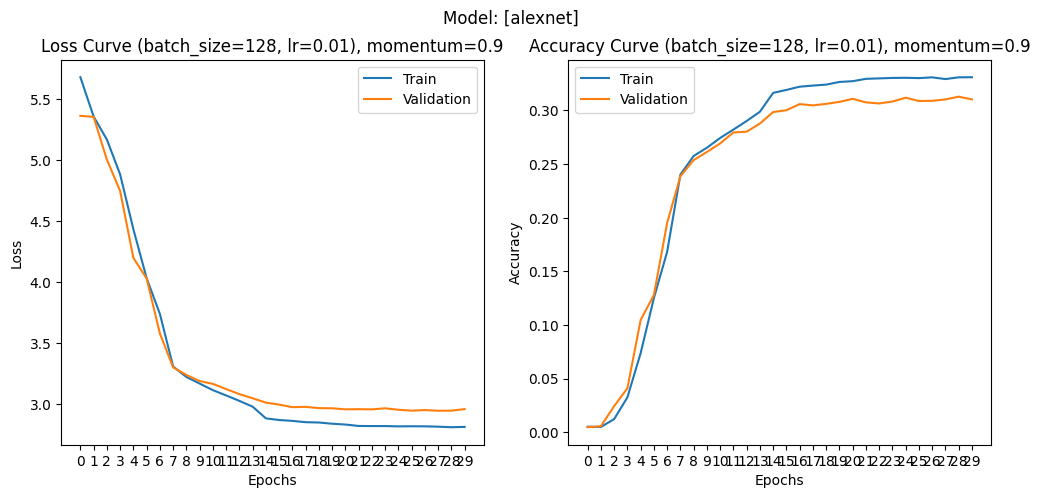

In [17]:
alexnet_trainer.test(test_dataloader)
alexnet_trainer.plot_metrics()